## Classification Methods
Compare different classifiers' performance on simulated & real world data  
Tianyue Niu

In [1]:
#import necessary packages
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
from tabulate import tabulate
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

### 1. Bayes Classifier

*Set random number generator seed*

In [2]:
np.random.seed(2)

*Simulate a dataset of N = 200 with X1, X2 where X1, X2 are random uniform variables between
[−1, 1].*

In [3]:
#create x1 and x2
x1 = np.random.uniform(-1,1,200)
x2 = np.random.uniform(-1,1,200)

*Calculate $Y =X_1+X_1^2+X_2+X_2^2+ε$, where ε∼N( μ=0, $σ^2$ =0.25).*

In [4]:
#create error term
error = np.random.normal(0, 0.5, 200)

In [5]:
#calculate Y
y = x1 + x1**2 + x2 + x2**2 + error

*Y is defined in terms of the log-odds of success on the domain [−∞, +∞]. Calculate the probability of success bounded between [0, 1].*


Given the log-odds function $log (\frac{p(x)}{1-p(x)}) = \beta_0 + \beta_1X$: $$p(X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}$$

In [6]:
#calculate probability according to the formula above
prob_success = math.e**y/(1+math.e**y)

*Plot each of the data points on a graph and use color to indicate if the observation was a success or a failure.*

In [7]:
success = prob_success > 0.5 #create boolean array for success
failure = prob_success <= 0.5 #create boolean array for failures

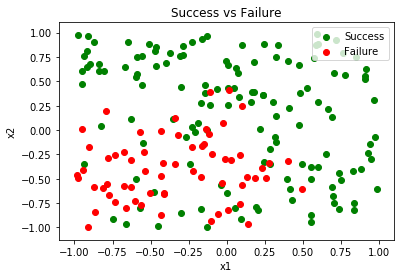

In [8]:
plt.scatter(x1[success], x2[success], color = 'green')
plt.scatter(x1[failure], x2[failure], color = 'red')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Success vs Failure')
plt.legend(['Success', 'Failure'], loc=1);

*Overlay the plot with Bayes decision boundary, calculated using X1,X2.*

In [9]:
X = np.column_stack((x1,x2)) #stack x1 and x2 together
X = pd.DataFrame(X) #convert to pandas data frame

In [10]:
gnb = GaussianNB()
gnb.fit(X, success)

GaussianNB(priors=None, var_smoothing=1e-09)

In [11]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
Z = gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

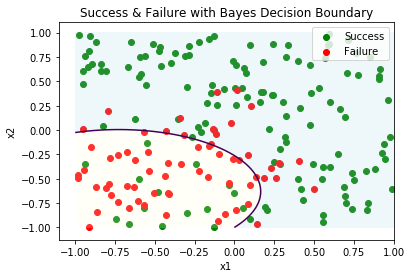

In [12]:
#plot original plot
plt.scatter(x1[success], x2[success], color = 'green')
plt.scatter(x1[failure], x2[failure], color = 'red')
#plot decision boundary
plt.contour(xx, yy, Z, [0.5])
#fill background
plt.contourf(xx, yy, Z, [0,0.5], colors = 'lightyellow', alpha=0.2)
plt.contourf(xx, yy, Z, [0.5,1], colors='lightblue', alpha=0.2)
#label axis
plt.xlabel('x1')
plt.ylabel('x2')
#create title
plt.title('Success & Failure with Bayes Decision Boundary')
#create legend
plt.legend(['Success','Failure'], loc=1);

### 2. LDA & QDA

*If the Bayes decision boundary is linear, do we expect LDA or QDA to perform better on the training set? On the test set?*

We would expect QDA to perform better on the training set because QDA is generally more flexible than LDA, so it might even fit training set's noise and gain a better estimate on the data. However, we would expect LDA to perform better on the test set because the decision boundary is linear, and so QDA might overfit, resulting in worse performance.

*Simulate a dataset of 1000 observations with X1 , X2 ∼ Uniform(−1, +1). Y is a binary
response variable defined by a Bayes decision boundary of f(X) = X1 + X2, where values 0 or greater are coded TRUE and values less than 0 or coded FALSE. Whereas your simulated Y is a function of X1 + X2 + ε where ε ∼ N (0, 1).*

In [13]:
#simulate 1000 observations under uniform distribution
x1_da = np.random.uniform(-1,1,1000)
x2_da = np.random.uniform(-1,1,1000)
error_term = np.random.normal (0,1,1000) 
y_da = x1_da + x2_da + error_term

In [14]:
#create binary y (an array of boolean)
y_da_binary = y_da > 0

*Randomly split data into 70/30% training/test sets.*

In [15]:
#split the data into training and testing set
X_da = np.column_stack((x1_da, x2_da))
X_da_train, X_da_test, y_da_train, y_da_test = train_test_split(X_da, y_da_binary, test_size=0.3)

*Use the training dataset to estimate LDA and QDA models. Calculate training/testing error.*

In [16]:
#fit LDA
lda = LDA()
lda.fit(X_da_train, y_da_train)
#fit QDA
qda = QDA()
qda.fit(X_da_train, y_da_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [17]:
print(tabulate([['LDA training', 1-lda.score(X_da_train,y_da_train)], 
                ['LDA test', 1-lda.score(X_da_test,y_da_test)], 
                ['QDA training', 1- qda.score(X_da_train, y_da_train)],
                ['QDA training', 1- qda.score(X_da_test, y_da_test)]], 
               headers = ['Type', 'Error Rate']))

Type            Error Rate
------------  ------------
LDA training      0.271429
LDA test          0.28
QDA training      0.274286
QDA training      0.276667


*Repeat (a) 1000 times. Summarize all the simulations’ error rates and report the results in tabular and graphical form.*

In [18]:
def simulate_1000():
    error_list = []
    for _ in range(1000): 
        x1_da = np.random.uniform(-1,1,1000)
        x2_da = np.random.uniform(-1,1,1000)
        error_term = np.random.normal (0,1,1000) 
        y_da = x1_da + x2_da + error_term
        y_da_binary = y_da > 0
        X_da = np.column_stack((x1_da, x2_da))
        X_da_train, X_da_test, y_da_train, y_da_test = train_test_split(X_da, y_da_binary, test_size=0.3)
        lda = LDA()
        lda.fit(X_da_train, y_da_train)
        qda = QDA()
        qda.fit(X_da_train, y_da_train)
        lda_train_error = 1- lda.score(X_da_train,y_da_train)
        lda_test_error = 1 - lda.score(X_da_test, y_da_test)
        qda_train_error = 1 - qda.score(X_da_train, y_da_train)
        qda_test_error = 1 - qda.score(X_da_test, y_da_test)
        error_list.append([lda_train_error, lda_test_error, qda_train_error, qda_test_error])
    return error_list

In [19]:
error_list = simulate_1000() #simulate 1000 times

In [20]:
#create error rate dataframe
df = pd.DataFrame(error_list, columns=["lda_train_error", "lda_test_error", 
                                       "qda_train_error", "qda_test_error"])

In [21]:
#show first 10 rows of error results
df.head(10)

,lda_train_error,lda_test_error,qda_train_error,qda_test_error
0,0.254286,0.260000,0.257143,0.260000
1,0.274286,0.243333,0.274286,0.246667
2,0.288571,0.266667,0.284286,0.273333
3,0.257143,0.286667,0.254286,0.286667
4,0.268571,0.236667,0.268571,0.240000
5,0.267143,0.263333,0.262857,0.263333
6,0.274286,0.296667,0.271429,0.293333
7,0.270000,0.276667,0.275714,0.273333
8,0.301429,0.276667,0.291429,0.276667
9,0.277143,0.276667,0.274286,0.280000


In [22]:
#get summary statistics
df.describe()

,lda_train_error,lda_test_error,qda_train_error,qda_test_error
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.273194,0.277057,0.272394,0.277230
std,0.017100,0.025820,0.017066,0.026032
min,0.228571,0.203333,0.222857,0.206667
25%,0.261429,0.260000,0.260000,0.260000
50%,0.272857,0.276667,0.272857,0.276667
75%,0.285714,0.296667,0.282857,0.293333
max,0.322857,0.360000,0.322857,0.363333


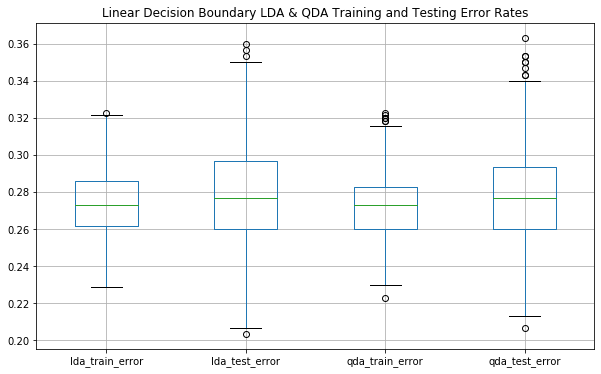

In [23]:
#plot error rates in the same plot to compare
df.boxplot(figsize=(10,6))
plt.title('Linear Decision Boundary LDA & QDA Training and Testing Error Rates');

The mean error rate from 1000 simulations for LDA train is 0.273194, LDA test is 0.277057, QDA train is  0.272394, and QDA test is 0.277230. We see that QDA's error rate in fitting the training data is the lowest (0.272394), but at the same time it also has the highest error rate (0.277230) in fitting the test data. However, the differences between QDA and LDA's performances on training/testing data are not very significant.

This is also shown in the box plot: the four means are not significantly different from each other.  However, we do see a wider variance in test errors compared with training errors. 

### 3. Non-linear Bayes Decision Boundary

*If the Bayes decision boundary is non-linear, do we expect LDA or QDA to perform better on the training set? On the test set?*

In this case, we would expect QDA to perform better because the bayes decision boundary is non-linear. QDA's flexibility would help it perform better in non-linear situations.


In [1]:
#simulate 1000 times to compare results

In [24]:
def simulate_1000_non_linear():
    error_list = []
    for _ in range(1000): 
        x1_da = np.random.uniform(-1,1,1000)
        x2_da = np.random.uniform(-1,1,1000)
        error_term = np.random.normal (0,1,1000) 
        y_da = x1_da + x1_da**2 + x2_da + x2_da**2 + error_term
        y_da_binary = y_da > 0
        X_da = np.column_stack((x1_da, x2_da))
        X_da_train, X_da_test, y_da_train, y_da_test = train_test_split(X_da, y_da_binary, test_size=0.3)
        lda = LDA()
        lda.fit(X_da_train, y_da_train)
        qda = QDA()
        qda.fit(X_da_train, y_da_train)
        lda_train_error = 1- lda.score(X_da_train,y_da_train)
        lda_test_error = 1 - lda.score(X_da_test, y_da_test)
        qda_train_error = 1 - qda.score(X_da_train, y_da_train)
        qda_test_error = 1 - qda.score(X_da_test, y_da_test)
        error_list.append([lda_train_error, lda_test_error, qda_train_error, qda_test_error])
    return error_list

In [25]:
error_non_linear = simulate_1000_non_linear()

In [26]:
#create error rate dataframe
df_nl = pd.DataFrame(error_non_linear, columns=["lda_train_error", "lda_test_error", 
                                                "qda_train_error", "qda_test_error"])

In [27]:
#show summary statistics
df_nl.describe()

,lda_train_error,lda_test_error,qda_train_error,qda_test_error
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.272793,0.275303,0.259290,0.262457
std,0.017181,0.025388,0.016377,0.024951
min,0.220000,0.196667,0.204286,0.186667
25%,0.261429,0.256667,0.248571,0.243333
50%,0.271429,0.273333,0.260000,0.263333
75%,0.284286,0.293333,0.270000,0.280000
max,0.341429,0.360000,0.312857,0.346667


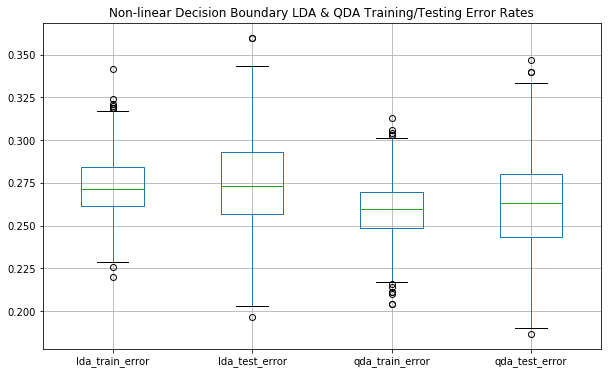

In [28]:
#show box plots
df_nl.boxplot(figsize=(10,6))
plt.title('Non-linear Decision Boundary LDA & QDA Training/Testing Error Rates');

From the above table and graph, we see that mean LDA train error rate is 0.272793, mean QDA train error rate is 0.259290, mean LDA test error rate is 0.275303, and mean QDA test error is 0.262457. QDA do perform better in both testing and training data. This corresponds to our previous expectation that QDA is going to perform better in a non-linear setting.

### 4 Sample size & LDA-QDA

*In general, as sample size n increases, do we expect the test error rate of QDA relative to LDA to improve, decline, or be unchanged? Why?*

In general, we would expect QDA to perform better than LDA because as the sample size gets larger, QDA as a more flexible model would be less affected by overfitting & perform better due to its flexibility.

*Use the non-linear Bayes decision boundary approach and vary n across the simulations (e.g., simulate 1000 times for n = c(1e02, 1e03, 1e04, 1e05).*

In [53]:
def simulate_sample (n):
#input: n = sample size
#output: a list containing lda & eda's training and test errors for 1000 simulation
    error_list = []
    for _ in range(1000): 
        x1_da = np.random.uniform(-1,1,n)
        x2_da = np.random.uniform(-1,1,n)
        error_term = np.random.normal (0,1,n) 
        y_da = x1_da + x1_da**2 + x2_da + x2_da**2 + error_term
        y_da_binary = y_da > 0
        X_da = np.column_stack((x1_da, x2_da))
        X_da_train, X_da_test, y_da_train, y_da_test = train_test_split(X_da, y_da_binary, test_size=0.3)
        lda = LDA()
        lda.fit(X_da_train, y_da_train)
        qda = QDA()
        qda.fit(X_da_train, y_da_train)
        lda_train_error = 1- lda.score(X_da_train,y_da_train)
        lda_test_error = 1 - lda.score(X_da_test, y_da_test)
        qda_train_error = 1 - qda.score(X_da_train, y_da_train)
        qda_test_error = 1 - qda.score(X_da_test, y_da_test)
        error_list.append([lda_train_error, lda_test_error, qda_train_error, qda_test_error])
    return error_list

In [54]:
def create_dataframe (n, no_of_zeros):
#input: n = sample size, no_of_zeros = used to format column names
#output: a panda dataframe
    temp = simulate_sample(n)
    df_error = pd.DataFrame(temp, columns = ["ldf_train_error_100{}".format('0'*no_of_zeros), 
                                             "lda_test_error_100{}".format('0'*no_of_zeros), 
                                             "qda_train_error_100{}".format('0'*no_of_zeros), 
                                             "qda_test_error_100{}".format('0'*no_of_zeros)])
    return df_error

In [55]:
#create dataframes for different sample sizes
df_error_100 = create_dataframe(100, 0)
df_error_1k = create_dataframe(1000, 1)
df_error_10k = create_dataframe(10000, 2)
df_error_100k = create_dataframe(100000, 3)

In [56]:
#create final df (concatenate the four dfs above)
df = pd.concat([df_error_100, df_error_1k, df_error_10k, df_error_100k], axis=1)

In [57]:
df.head(5)

,ldf_train_error_100,lda_test_error_100,qda_train_error_100,qda_test_error_100,ldf_train_error_1000,lda_test_error_1000,qda_train_error_1000,qda_test_error_1000,ldf_train_error_10000,lda_test_error_10000,qda_train_error_10000,qda_test_error_10000,ldf_train_error_100000,lda_test_error_100000,qda_train_error_100000,qda_test_error_100000
0,0.314286,0.300000,0.285714,0.266667,0.265714,0.273333,0.247143,0.253333,0.273000,0.278000,0.258286,0.266333,0.275229,0.274200,0.263171,0.261533
1,0.271429,0.266667,0.242857,0.366667,0.271429,0.236667,0.261429,0.230000,0.280286,0.271667,0.269000,0.263000,0.271086,0.272067,0.258586,0.258933
2,0.242857,0.233333,0.228571,0.300000,0.277143,0.340000,0.264286,0.303333,0.275429,0.273667,0.260571,0.258667,0.272429,0.270333,0.260914,0.257067
3,0.171429,0.233333,0.171429,0.200000,0.261429,0.233333,0.241429,0.233333,0.271143,0.278000,0.258857,0.267000,0.272471,0.270100,0.260214,0.256033
4,0.314286,0.166667,0.314286,0.200000,0.267143,0.250000,0.254286,0.260000,0.272714,0.277667,0.260286,0.260333,0.274471,0.274333,0.261300,0.261833


*Plot the test error rate for the LDA and QDA models as it changes over all of these values of n*

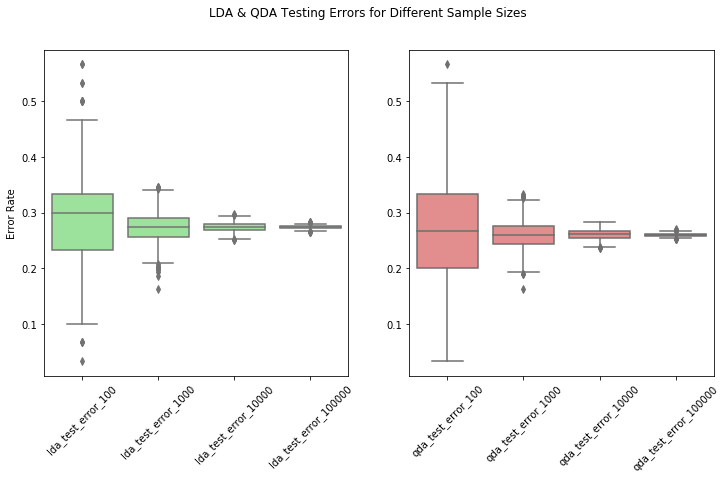

In [69]:
#plot testing data error rates
fig= plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
sb.boxplot(data=df[['lda_test_error_100','lda_test_error_1000',
                   'lda_test_error_10000','lda_test_error_100000']],palette = ['lightgreen'])
plt.xticks(rotation=45)
plt.ylabel('Error Rate')
ax2 = plt.subplot(122)
sb.boxplot(data=df[['qda_test_error_100','qda_test_error_1000',
                   'qda_test_error_10000','qda_test_error_100000']],palette = ['lightcoral'])
plt.xticks(rotation=45)
fig.suptitle('LDA & QDA Testing Errors for Different Sample Sizes');

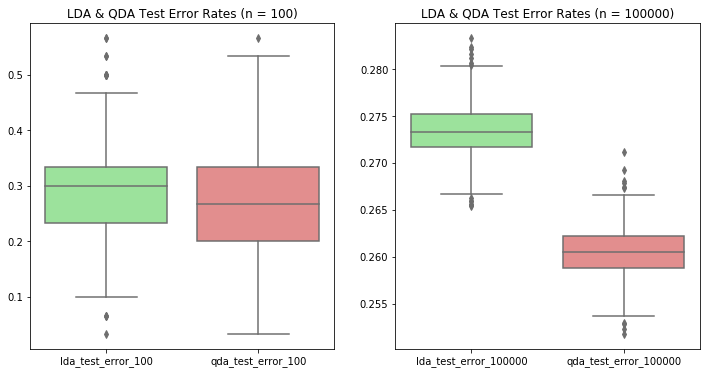

In [72]:
fig= plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
sb.boxplot(data=df[['lda_test_error_100', 'qda_test_error_100']],palette = ['lightgreen','lightcoral'])
plt.title('LDA & QDA Test Error Rates (n = 100)')
ax2 = plt.subplot(122)
sb.boxplot(data=df[['lda_test_error_100000', 'qda_test_error_100000']],palette = ['lightgreen','lightcoral'])
plt.title('LDA & QDA Test Error Rates (n = 100000)');

From the above graphs we see that for both classifiers, mean testing error rates shrink as sample size becomes larger. However, as sample size gets larger, we see that qda mean test error becomes significantly smaller than lda mean test error, which matches our expectation.

### 5. Modeling Voter Turnout Using Real World Data

In [35]:
df = pd.read_csv('mental_health.csv')

In [36]:
df.head(5)

,vote96,mhealth_sum,age,educ,black,female,married,inc10
0,1.0,0.0,60.0,12.0,0,0,0.0,4.8149
1,1.0,NaN,27.0,17.0,0,1,0.0,1.7387
2,1.0,1.0,36.0,12.0,0,0,1.0,8.8273
3,0.0,7.0,21.0,13.0,0,0,0.0,1.7387
4,0.0,NaN,35.0,16.0,0,1,0.0,4.8149


In [37]:
#we need to deal with missing values or otherwise won't be able to run classifiers
df.dropna(inplace=True)

*Split the data into a training and test set (70/30)*

In [38]:
y = df['vote96']
X = df[['mhealth_sum','age','educ','black','female','married','inc10']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

*Using the training set and all important predictors, estimate the following models with vote96 as the response variable:  
i. Logistic regression model  
ii. Linear discriminant model  
iii. Quadratic discriminant model  
iv. Naive Bayes (you can use the default hyperparameter settings)  
v. K-nearest neighbors with K = 1,2,...,10 (that is, 10 separate models varying K) and Euclidean distance metrics*  

In [39]:
#Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_error = 1-lr.score(X_test, y_test)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
#Linear Discriminant Model
lda = LDA()
lda.fit(X_train,y_train)
lda_error = 1-lda.score(X_test, y_test)

In [41]:
#Quadratic Discriminant Model
qda = QDA()
qda.fit(X_train,y_train)
qda_error = 1-qda.score(X_test, y_test)

In [42]:
#Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_error = 1-gnb.score(X_test, y_test)

In [43]:
#KNN
def fit_KNN(n):
    KNN = KNeighborsClassifier(n_neighbors=n)
    KNN.fit(X_train,y_train)
    KNN_error = 1-KNN.score(X_test, y_test)
    return KNN, KNN_error
    
KNN1, KNN1_error = fit_KNN(1)
KNN2, KNN2_error = fit_KNN(2)
KNN3, KNN3_error = fit_KNN(3)
KNN4, KNN4_error = fit_KNN(4)
KNN5, KNN5_error = fit_KNN(5)
KNN6, KNN6_error = fit_KNN(6)
KNN7, KNN7_error = fit_KNN(7)
KNN8, KNN8_error = fit_KNN(8)
KNN9, KNN9_error = fit_KNN(9)
KNN10, KNN10_error = fit_KNN(10)

*c. Using the test set, calculate the following model performance metrics*  
i. Error rate  


In [44]:
print(tabulate([['Logistic Regression test error', lr_error], 
                ['LDA test error', lda_error], 
                ['QDA test error', qda_error],
                ['Naive Bayes test error', gnb_error],
                ['KNN,n=1', KNN1_error],
                ['KNN,n=2', KNN2_error],
                ['KNN,n=3', KNN3_error],
                ['KNN,n=4', KNN4_error],
                ['KNN,n=5', KNN5_error],
                ['KNN,n=6', KNN6_error],
                ['KNN,n=7', KNN7_error],
                ['KNN,n=8', KNN8_error],
                ['KNN,n=9', KNN9_error],
                ['KNN,n=10', KNN10_error]], 
               headers = ['Type', 'Error Rate']))

Type                              Error Rate
------------------------------  ------------
Logistic Regression test error      0.277143
LDA test error                      0.26
QDA test error                      0.28
Naive Bayes test error              0.274286
KNN,n=1                             0.317143
KNN,n=2                             0.38
KNN,n=3                             0.291429
KNN,n=4                             0.337143
KNN,n=5                             0.317143
KNN,n=6                             0.317143
KNN,n=7                             0.322857
KNN,n=8                             0.311429
KNN,n=9                             0.314286
KNN,n=10                            0.3


ii. ROC curve(s) / Area under the curve (AUC)

In [73]:
def get_roc_auc(model, label):    
    # predict probabilities
    model_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    model_probs = model_probs[:, 1]
    #calcualte auc score
    model_auc = roc_auc_score(y_test, model_probs)
    # summarize scores
    print(label+ ': AUC = %.3f' % (model_auc))
    # calculate roc curves
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)
    # plot the roc curve for the model
    plt.plot(model_fpr, model_tpr, marker='.', label=label)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()

def plot_random_classifier():
    plt.figure(figsize=(10,8))
    # generate a random prediction line
    random_probs = [0 for _ in range(len(y_test))]
    # calculate scores
    random_auc = roc_auc_score(y_test, random_probs)
    random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)
    plt.plot(random_fpr, random_tpr, linestyle='--', label='Random Classifier')

Logistic Regression: AUC = 0.805
LDA: AUC = 0.804
QDA: AUC = 0.776
Naive Bayes: AUC = 0.784
knn1: AUC = 0.632
knn2: AUC = 0.662
knn3: AUC = 0.690
knn4: AUC = 0.693
knn5: AUC = 0.713
knn6: AUC = 0.721
knn7: AUC = 0.735
knn8: AUC = 0.727
knn9: AUC = 0.733
knn10: AUC = 0.740


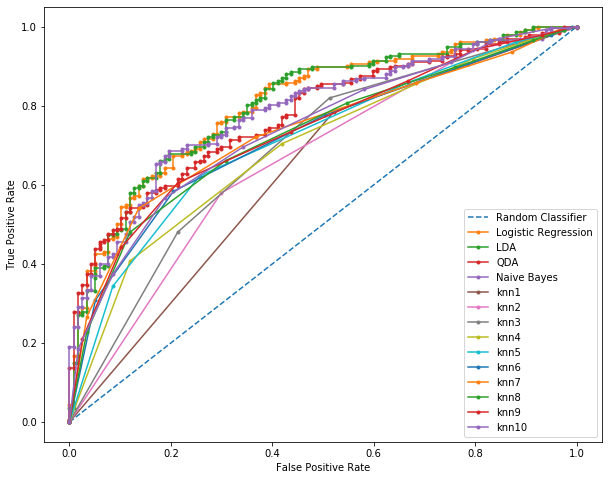

In [46]:
plot_random_classifier()

models = [lr, lda, qda, gnb, KNN1, KNN2,KNN3,KNN4,KNN5,KNN6,KNN7,KNN8,KNN9,KNN10]
labels = ['Logistic Regression', 'LDA', 'QDA', "Naive Bayes" ,
          'knn1','knn2','knn3','knn4','knn5','knn6','knn7','knn8','knn9','knn10']

count = 0
for model in models:
    get_roc_auc(model, labels[count])
    count+=1

In terms of accuracy, LDA, Logistic Regression and Naive Bayes were the three classifiers with the lowest error rate, with LDA being the best among the three in terms of accuracy with an error rate of 0.26.   
In terms of ROC/AUC, the best classifiers are logistic regression & LDA, Logistic Regression has an AUC of 0.805 and LDA has an AUC of 0.804. 